# **Previsión de Series Temporales con RNN (LSTM y GRU) en PyTorch**
## **Dataset: Pasajeros de Aerolínea (Air Passengers)**

**Objetivo del Notebook:**
Este notebook presenta un flujo de trabajo para construir, entrenar, evaluar y utilizar modelos de Redes Neuronales Recurrentes (RNNs), específicamente LSTM y GRU, para la previsión de series temporales utilizando **PyTorch**.

**Estructura del Notebook:**
1.  Carga de las librerías necesarias.
2.  Carga del dataset de series temporales (Air Passengers desde CSV).
3.  Visualización del dataset y Análisis Exploratorio de Datos (EDA).
4.  Preprocesamiento del dataset (escalado, creación de secuencias).
5.  Creación de los `DataLoader` de PyTorch.
6.  Definición y configuración de dos modelos RNN (LSTM y GRU).
7.  Entrenamiento y evaluación de los modelos.
8.  Inferencia (previsión) con el mejor modelo.
9.  Guardado del mejor modelo.

In [ ]:
# 1. Carga de las Librerías
# ------------------------------------------------------------------------------

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Pandas para la carga y manipulación de datos CSV
import pandas as pd

# NumPy para operaciones numéricas
import numpy as np

# Scikit-learn para preprocesamiento (escalado) y métricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Matplotlib para visualización
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Para formatear fechas en los gráficos

# Otras utilidades
import os
import datetime
import math # Para sqrt en RMSE

# Comprobación de versiones
print(f"PyTorch Version: {torch.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")
# print(f"Scikit-learn Version: {sklearn.__version__}") # Si se importa sklearn directamente

# Configuraciones opcionales para Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6] # Ajustar tamaño para series temporales
plt.rcParams['font.size'] = 12

# Determinar el dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsando dispositivo: {device}")

PyTorch Version: 2.6.0+cu124
Pandas Version: 2.2.2
NumPy Version: 2.0.2

Usando dispositivo: cuda


## **2. Carga del Dataset de Series Temporales**

En esta sección, cargaremos el dataset "Air Passengers".
Asumiremos que está en un archivo CSV llamado `AirPassengers.csv` con columnas "Month" y "#Passengers".
Realizaremos una inspección inicial de los datos.

**Nota:** Si no tienes el archivo `AirPassengers.csv`, puedes buscarlo online (es un dataset muy común)
o usar otros datasets de series temporales disponibles.

In [2]:
# 2. Carga del Dataset
# ------------------------------------------------------------------------------

# --- Constantes Globales Clave ---
# Esta constante BATCH_SIZE es fundamental y se utiliza en celdas posteriores (como la Celda 10)
# para crear los DataLoaders.
# ¡ASEGÚRATE DE QUE ESTA CELDA SE EJECUTE ANTES DE LAS CELDAS QUE LA NECESITAN!
BATCH_SIZE = 32
# --- Fin de Constantes Globales Clave ---

# Ruta al archivo CSV. Ajusta esta ruta si es necesario.
# Comúnmente, este archivo tiene columnas 'Month' y '#Passengers' o similar.
csv_path = 'AirPassengers.csv' # ASEGÚRATE DE QUE ESTE ARCHIVO EXISTA EN LA RUTA ESPECIFICADA

try:
    # Cargar el dataset
    df = pd.read_csv(csv_path)
    print(f"Dataset '{csv_path}' cargado exitosamente.")

    # Inspección inicial
    print("\n--- Primeras filas del dataset: ---")
    print(df.head())

    print("\n--- Información del DataFrame: ---")
    df.info()

    # Asumir que la columna de pasajeros es la segunda (índice 1) si no se llama '#Passengers'
    # y la columna de fecha es la primera (índice 0)
    if '#Passengers' in df.columns:
        passengers_col_name = '#Passengers'
    elif 'Passengers' in df.columns:
        passengers_col_name = 'Passengers'
    else:
        print(f"Advertencia: No se encontró la columna '#Passengers' o 'Passengers'. Usando la segunda columna: {df.columns[1]}")
        passengers_col_name = df.columns[1]

    if 'Month' in df.columns:
        date_col_name = 'Month'
    else:
        print(f"Advertencia: No se encontró la columna 'Month'. Usando la primera columna: {df.columns[0]}")
        date_col_name = df.columns[0]

    # Convertir la columna de fecha a datetime y establecerla como índice
    df[date_col_name] = pd.to_datetime(df[date_col_name])
    df.set_index(date_col_name, inplace=True)

    # Seleccionar solo la serie de pasajeros
    time_series_data = df[passengers_col_name]

    print(f"\n--- Serie temporal de '{passengers_col_name}' (primeras filas): ---")
    print(time_series_data.head())

except FileNotFoundError:
    print(f"Error: El archivo '{csv_path}' no fue encontrado.")
    print("Por favor, descarga el dataset 'AirPassengers.csv' y colócalo en la ruta correcta o actualiza 'csv_path'.")
    # Crear un DataFrame de ejemplo si el archivo no se encuentra, para que el resto del notebook pueda ejecutarse parcialmente.
    print("Creando un dataset de ejemplo para demostración...")
    dates_example = pd.date_range(start='1949-01-01', periods=144, freq='MS')
    values_example = np.linspace(100, 600, 144) + np.random.randn(144)*20 + np.sin(np.arange(144)/6)*50
    values_example = np.maximum(50, values_example).astype(int) # asegurar positivos
    df = pd.DataFrame({'Month': dates_example, '#Passengers': values_example})
    df['Month'] = pd.to_datetime(df['Month'])
    df.set_index('Month', inplace=True)
    passengers_col_name = '#Passengers'
    time_series_data = df[passengers_col_name]
    print("Dataset de ejemplo creado.")

Dataset 'AirPassengers.csv' cargado exitosamente.

--- Primeras filas del dataset: ---
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

--- Información del DataFrame: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB

--- Serie temporal de '#Passengers' (primeras filas): ---
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


## **3. Visualización del Dataset y Análisis Exploratorio de Datos (EDA)**

Visualizaremos la serie temporal para identificar patrones como tendencia, estacionalidad y posibles anomalías.
También verificaremos si hay valores faltantes.


--- 3.1 Visualización de la Serie Temporal Completa ---


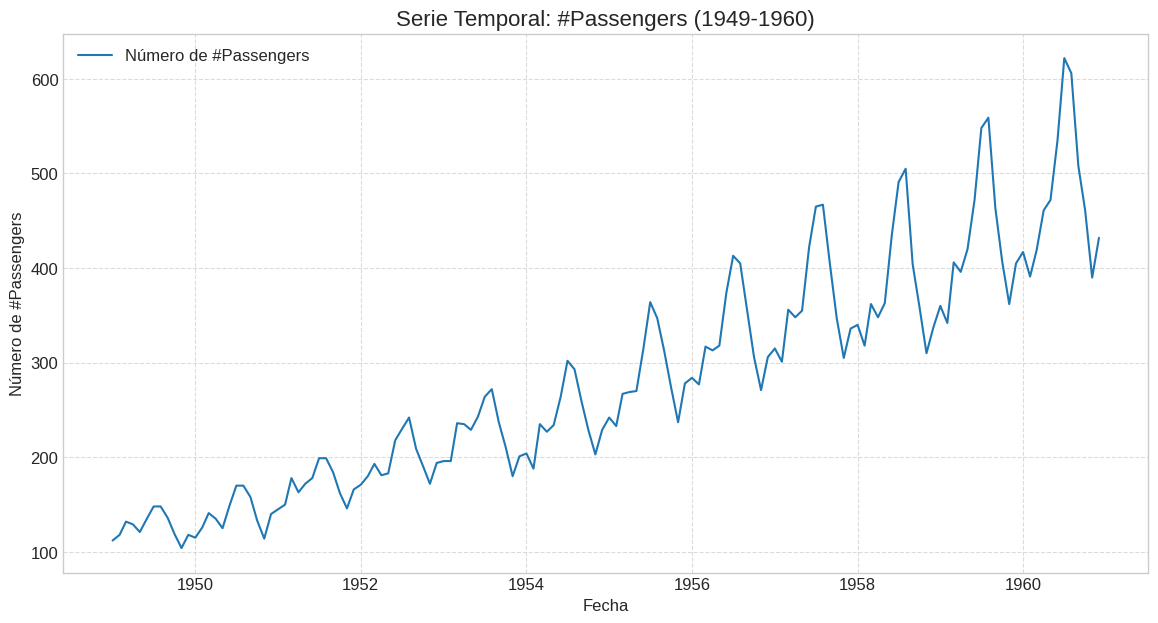


--- 3.2 Verificación de Valores Faltantes ---
Número de valores faltantes en la serie: 0


In [3]:
# 3. Visualización del Dataset y EDA
# ------------------------------------------------------------------------------

if 'time_series_data' in locals():
    # 3.1 Visualización de la Serie Temporal Completa
    print("\n--- 3.1 Visualización de la Serie Temporal Completa ---")
    plt.figure(figsize=(14, 7))
    plt.plot(time_series_data.index, time_series_data.values, label=f'Número de {passengers_col_name}')
    plt.title(f'Serie Temporal: {passengers_col_name} (1949-1960)', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel(f'Número de {passengers_col_name}', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    # Formatear el eje x para mostrar años
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2)) # Marcas cada 2 años
    plt.show()

    # 3.2 Verificación de Valores Faltantes
    print("\n--- 3.2 Verificación de Valores Faltantes ---")
    missing_values = time_series_data.isnull().sum()
    print(f"Número de valores faltantes en la serie: {missing_values}")
    if missing_values > 0:
        print("Advertencia: Existen valores faltantes. Se deberían tratar (ej. interpolación, eliminación).")
        # Para este ejemplo, no implementaremos el tratamiento de faltantes.
else:
    print("No se pudo cargar `time_series_data`. Saltando EDA.")

## **4. Preprocesamiento del Dataset**

El preprocesamiento para modelos RNN de series temporales generalmente incluye:
1.  **Escalado de Datos:** Los modelos de redes neuronales suelen funcionar mejor con datos escalados (ej. entre 0 y 1 o -1 y 1). Usaremos `MinMaxScaler`.
2.  **División en Entrenamiento y Prueba:** Es crucial que la división sea cronológica para series temporales. No se deben mezclar datos del futuro en el conjunto de entrenamiento.
3.  **Creación de Secuencias:** Las RNNs (LSTM/GRU) procesan secuencias de datos. Necesitamos transformar nuestra serie temporal en pares de (secuencia_de_entrada, valor_objetivo).
    * `sequence_length` (o lookback): Número de pasos temporales pasados que se usarán como entrada.
    * `target_steps` (o horizon): Número de pasos futuros a predecir (aquí, 1).

In [4]:
# 4. Preprocesamiento del Dataset
# ------------------------------------------------------------------------------

if 'time_series_data' in locals():
    # 4.1 Escalado de Datos
    print("\n--- 4.1 Escalado de Datos ---")
    scaler = MinMaxScaler(feature_range=(-1, 1)) # Escalar a [-1, 1] es común para LSTMs
    # scaler = MinMaxScaler(feature_range=(0, 1)) # Escalar a [0, 1] también es una opción

    # El método fit_transform espera un array 2D, así que convertimos la serie 1D
    data_scaled = scaler.fit_transform(time_series_data.values.reshape(-1, 1))
    print(f"Forma de los datos escalados: {data_scaled.shape}")
    print(f"Primeros 5 valores escalados:\n{data_scaled[:5]}")

    # 4.2 División en Entrenamiento y Prueba (Cronológica)
    print("\n--- 4.2 División en Entrenamiento y Prueba ---")
    # Por ejemplo, usar el 80% para entrenamiento y el 20% para prueba
    train_size = int(len(data_scaled) * 0.80)
    test_size = len(data_scaled) - train_size

    train_data_scaled = data_scaled[0:train_size, :]
    test_data_scaled = data_scaled[train_size:len(data_scaled), :]

    print(f"Tamaño del conjunto de entrenamiento escalado: {len(train_data_scaled)}")
    print(f"Tamaño del conjunto de prueba escalado: {len(test_data_scaled)}")

    # 4.3 Creación de Secuencias
    print("\n--- 4.3 Creación de Secuencias ---")
    def create_sequences(input_data, sequence_length, target_steps=1):
        """
        Crea secuencias de entrada y etiquetas objetivo para modelos RNN.
        Args:
            input_data (np.array): Array de la serie temporal (ya escalada).
            sequence_length (int): Número de pasos temporales pasados a usar como entrada.
            target_steps (int): Número de pasos futuros a predecir. Default 1.
        Returns:
            tuple: (np.array de secuencias de entrada, np.array de etiquetas objetivo)
        """
        X, y = [], []
        for i in range(len(input_data) - sequence_length - (target_steps - 1)):
            # La secuencia de entrada
            seq_in = input_data[i:(i + sequence_length), 0] # Tomar 'sequence_length' valores
            # La etiqueta objetivo (el/los siguiente/s valor/es)
            seq_out = input_data[(i + sequence_length):(i + sequence_length + target_steps), 0]
            X.append(seq_in)
            y.append(seq_out)
        return np.array(X), np.array(y)

    SEQUENCE_LENGTH = 12  # Usar los últimos 12 meses para predecir el siguiente
    TARGET_STEPS = 1      # Predecir 1 mes adelante

    X_train, y_train = create_sequences(train_data_scaled, SEQUENCE_LENGTH, TARGET_STEPS)
    X_test, y_test = create_sequences(test_data_scaled, SEQUENCE_LENGTH, TARGET_STEPS)

    print(f"Forma de X_train: {X_train.shape}") # Debería ser (num_samples, sequence_length)
    print(f"Forma de y_train: {y_train.shape}")   # Debería ser (num_samples, target_steps)
    print(f"Forma de X_test: {X_test.shape}")
    print(f"Forma de y_test: {y_test.shape}")

    # Convertir a Tensores PyTorch
    # RNNs en PyTorch esperan la entrada como (seq_len, batch, input_size) o (batch, seq_len, input_size)
    # Si batch_first=True en la capa RNN, entonces (batch, seq_len, input_size)
    # Nuestra X_train/X_test es (num_samples, sequence_length). Necesitamos añadir la dimensión de 'features'.
    # Para series univariadas, input_size (num_features) es 1.
    X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(-1) # (num_samples, seq_len, 1)
    y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(-1) # (num_samples, target_steps, 1)
    X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(-1)
    y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(-1)
    # Si target_steps es 1 y la última capa lineal tiene 1 salida, y_train/y_test puede ser solo (num_samples, 1)
    # y no (num_samples, 1, 1). Vamos a ajustar y_train/y_test si TARGET_STEPS = 1.
    if TARGET_STEPS == 1:
        y_train_tensor = y_train_tensor.squeeze(-1) # (num_samples, 1)
        y_test_tensor = y_test_tensor.squeeze(-1)   # (num_samples, 1)


    print(f"\nForma de X_train_tensor: {X_train_tensor.shape}")
    print(f"Forma de y_train_tensor: {y_train_tensor.shape}")

else:
    print("No se pudo cargar `time_series_data`. Saltando Preprocesamiento.")
    # Definir tensores vacíos para que el resto del notebook no falle catastróficamente
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = torch.empty(0), torch.empty(0), torch.empty(0), torch.empty(0)

print("\n--- Fin de Preprocesamiento ---")


--- 4.1 Escalado de Datos ---
Forma de los datos escalados: (144, 1)
Primeros 5 valores escalados:
[[-0.96911197]
 [-0.94594595]
 [-0.89189189]
 [-0.9034749 ]
 [-0.93436293]]

--- 4.2 División en Entrenamiento y Prueba ---
Tamaño del conjunto de entrenamiento escalado: 115
Tamaño del conjunto de prueba escalado: 29

--- 4.3 Creación de Secuencias ---
Forma de X_train: (103, 12)
Forma de y_train: (103, 1)
Forma de X_test: (17, 12)
Forma de y_test: (17, 1)

Forma de X_train_tensor: torch.Size([103, 12, 1])
Forma de y_train_tensor: torch.Size([103, 1])

--- Fin de Preprocesamiento ---


## **5. Creación de los `DataLoader` de PyTorch**

Con las secuencias de entrenamiento y prueba ya convertidas a tensores PyTorch, crearemos `Dataset` personalizados y luego los `DataLoader` correspondientes.

Esto facilitará la iteración por lotes (batches) durante el entrenamiento y la evaluación.

In [5]:
# 5. Creación de los DataLoader
# ------------------------------------------------------------------------------

class TimeSeriesDataset(Dataset):
    """Dataset personalizado para secuencias de series temporales."""
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

# X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor deberían estar definidos
# en la Celda 8 (Preprocesamiento)
if 'X_train_tensor' in locals() and X_train_tensor.nelement() > 0:
    train_dataset_ts = TimeSeriesDataset(X_train_tensor, y_train_tensor)
    test_dataset_ts = TimeSeriesDataset(X_test_tensor, y_test_tensor)

    # Aquí se usa BATCH_SIZE. Si Celda 4 no se ejecutó, dará error.
    train_dataloader_ts = DataLoader(train_dataset_ts, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    test_dataloader_ts = DataLoader(test_dataset_ts, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    print(f"DataLoaders `train_dataloader_ts` y `test_dataloader_ts` creados.")
    print(f"Número de lotes en train_dataloader_ts: {len(train_dataloader_ts)}")
    print(f"Número de lotes en test_dataloader_ts: {len(test_dataloader_ts)}")

    # Verificar un lote (opcional)
    # x_batch_check, y_batch_check = next(iter(train_dataloader_ts))
    # print(f"Forma del lote de X de entrenamiento: {x_batch_check.shape}")
    # print(f"Forma del lote de y de entrenamiento: {y_batch_check.shape}")
else:
    print("Tensores de entrenamiento/prueba están vacíos o no definidos "
          "(probablemente por fallo en carga de datos o preprocesamiento). "
          "No se pueden crear DataLoaders.")
    train_dataloader_ts, test_dataloader_ts = None, None

DataLoaders `train_dataloader_ts` y `test_dataloader_ts` creados.
Número de lotes en train_dataloader_ts: 3
Número de lotes en test_dataloader_ts: 1


## **6. Definición de Modelos RNN (LSTM y GRU)**

Definiremos dos modelos basados en RNN:
1.  **Modelo LSTM:** Utilizará una o más capas LSTM seguidas de una capa lineal para la predicción.
2.  **Modelo GRU:** Similar, pero utilizando capas GRU.

Ambos modelos tomarán secuencias de entrada y predecirán el valor del siguiente paso temporal.
Las capas LSTM y GRU en PyTorch esperan la entrada con `batch_first=True` como `(batch_size, seq_len, input_size/num_features)`.
Nuestra `input_size` (número de features por paso temporal) es 1 para esta serie univariada.

In [6]:
# 6. Definición de Modelos RNN (LSTM y GRU)
# ------------------------------------------------------------------------------

INPUT_SIZE_RNN = 1 # Número de features en cada paso temporal (1 para univariada)
HIDDEN_SIZE_RNN = 64 # Número de neuronas en la capa oculta de LSTM/GRU
NUM_LAYERS_RNN = 1   # Número de capas recurrentes apiladas
OUTPUT_SIZE_RNN = TARGET_STEPS # Predecir `TARGET_STEPS` adelante (aquí 1)

class LSTMModel(nn.Module):
    def __init__(self, input_s, hidden_s, num_l, output_s, dropout_p=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_s
        self.num_layers = num_l

        self.lstm = nn.LSTM(input_s, hidden_s, num_l, batch_first=True, dropout=dropout_p if num_l > 1 else 0)
        # batch_first=True -> la entrada y salida son (batch, seq, feature)
        # dropout solo se aplica si num_layers > 1

        self.fc = nn.Linear(hidden_s, output_s) # Capa lineal para la salida

    def forward(self, x):
        # Inicializar estado oculto y estado de celda
        # h0 shape: (num_layers * num_directions, batch, hidden_size)
        # c0 shape: (num_layers * num_directions, batch, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decodificar el estado oculto del último paso temporal
        # Queremos la salida del último paso de la secuencia para la predicción
        out = self.fc(out[:, -1, :]) # out[:, -1, :] da (batch_size, hidden_size)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_s, hidden_s, num_l, output_s, dropout_p=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_s
        self.num_layers = num_l

        self.gru = nn.GRU(input_s, hidden_s, num_l, batch_first=True, dropout=dropout_p if num_l > 1 else 0)
        self.fc = nn.Linear(hidden_s, output_s)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Instanciar los modelos
modelo_lstm_pt = LSTMModel(INPUT_SIZE_RNN, HIDDEN_SIZE_RNN, NUM_LAYERS_RNN, OUTPUT_SIZE_RNN)
modelo_gru_pt = GRUModel(INPUT_SIZE_RNN, HIDDEN_SIZE_RNN, NUM_LAYERS_RNN, OUTPUT_SIZE_RNN)

print("--- Modelo LSTM (PyTorch) ---")
print(modelo_lstm_pt)
# from torchinfo import summary
# if X_train_tensor.nelement() > 0: # Solo si hay datos para inferir tamaño de lote
#     summary(modelo_lstm_pt, input_size=(BATCH_SIZE, SEQUENCE_LENGTH, INPUT_SIZE_RNN), device="cpu")

print("\n--- Modelo GRU (PyTorch) ---")
print(modelo_gru_pt)
# if X_train_tensor.nelement() > 0:
#     summary(modelo_gru_pt, input_size=(BATCH_SIZE, SEQUENCE_LENGTH, INPUT_SIZE_RNN), device="cpu")

print("\nModelos RNN (PyTorch) definidos.")

--- Modelo LSTM (PyTorch) ---
LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

--- Modelo GRU (PyTorch) ---
GRUModel(
  (gru): GRU(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Modelos RNN (PyTorch) definidos.


## **7. Entrenamiento y Evaluación de los Modelos (PyTorch)**

El proceso será similar al del notebook de CNNs en PyTorch:
1.  Definir una función de pérdida: `nn.MSELoss` (Error Cuadrático Medio), común para regresión.
2.  Definir un optimizador: `optim.Adam`.
3.  Crear funciones para el bucle de entrenamiento y el de evaluación.
4.  Entrenar y evaluar ambos modelos (LSTM y GRU).
5.  Graficar las curvas de pérdida de entrenamiento y validación.

Las métricas principales serán MSE y RMSE (Raíz del Error Cuadrático Medio).


--- Entrenando y Evaluando: LSTM (PyTorch) en cuda ---
Iniciando Época 1/150 para LSTM (PyTorch)
    Época [1/150], Lote [1/3], Pérdida Lote: 0.350036
    Época [1/150], Lote [2/3], Pérdida Lote: 0.203144
    Época [1/150], Lote [3/3], Pérdida Lote: 0.254422
  FIN ÉPOCA 1/150: Pérdida Entr: 0.269201, Pérdida Val: 0.246738
    Nueva mejor Pérdida Validación: 0.246738
Iniciando Época 2/150 para LSTM (PyTorch)
    Época [2/150], Lote [1/3], Pérdida Lote: 0.200699
    Época [2/150], Lote [2/3], Pérdida Lote: 0.272452
    Época [2/150], Lote [3/3], Pérdida Lote: 0.190398
  FIN ÉPOCA 2/150: Pérdida Entr: 0.221183, Pérdida Val: 0.270733
Iniciando Época 3/150 para LSTM (PyTorch)
    Época [3/150], Lote [1/3], Pérdida Lote: 0.177617
    Época [3/150], Lote [2/3], Pérdida Lote: 0.218237
    Época [3/150], Lote [3/3], Pérdida Lote: 0.160827
  FIN ÉPOCA 3/150: Pérdida Entr: 0.185560, Pérdida Val: 0.297552
Iniciando Época 4/150 para LSTM (PyTorch)
    Época [4/150], Lote [1/3], Pérdida Lote: 0.150

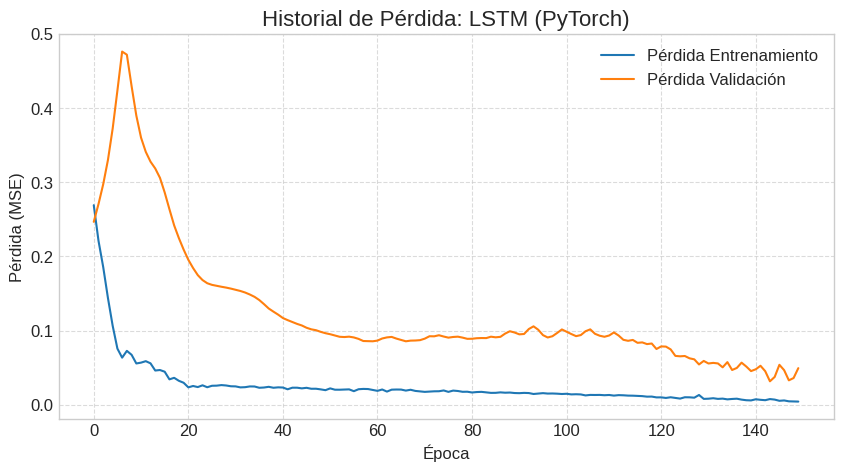


Mejor resultado para LSTM (PyTorch) en época 144: Pérdida Val (MSE) = 0.031552, RMSE Val = 0.1776

--- Entrenando y Evaluando: GRU (PyTorch) en cuda ---
Iniciando Época 1/150 para GRU (PyTorch)
    Época [1/150], Lote [1/3], Pérdida Lote: 0.373255
    Época [1/150], Lote [2/3], Pérdida Lote: 0.358740
    Época [1/150], Lote [3/3], Pérdida Lote: 0.302028
  FIN ÉPOCA 1/150: Pérdida Entr: 0.344674, Pérdida Val: 0.203156
    Nueva mejor Pérdida Validación: 0.203156
Iniciando Época 2/150 para GRU (PyTorch)
    Época [2/150], Lote [1/3], Pérdida Lote: 0.322790
    Época [2/150], Lote [2/3], Pérdida Lote: 0.289794
    Época [2/150], Lote [3/3], Pérdida Lote: 0.272256
  FIN ÉPOCA 2/150: Pérdida Entr: 0.294947, Pérdida Val: 0.229128
Iniciando Época 3/150 para GRU (PyTorch)
    Época [3/150], Lote [1/3], Pérdida Lote: 0.251293
    Época [3/150], Lote [2/3], Pérdida Lote: 0.218478
    Época [3/150], Lote [3/3], Pérdida Lote: 0.266155
  FIN ÉPOCA 3/150: Pérdida Entr: 0.245309, Pérdida Val: 0.2589

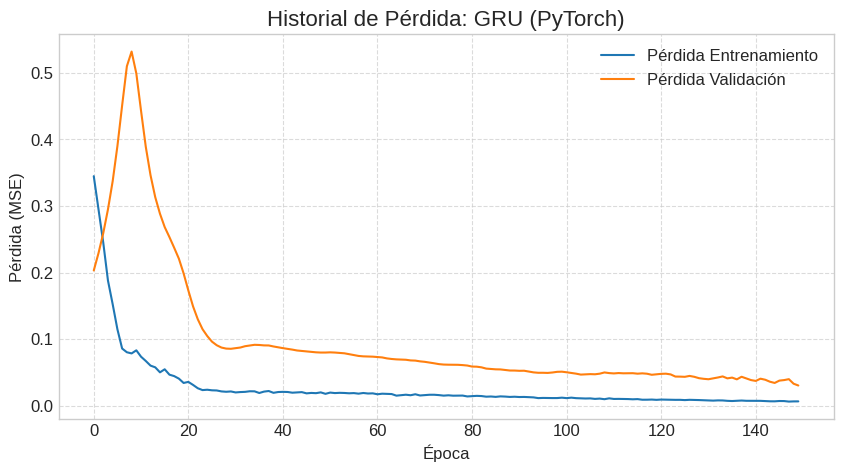


Mejor resultado para GRU (PyTorch) en época 150: Pérdida Val (MSE) = 0.030591, RMSE Val = 0.1749

--- Resumen de Resultados (PyTorch - Series Temporales) ---
LSTM: Mejor Pérdida Val (MSE) = 0.031552, RMSE Val = 0.1776
GRU:  Mejor Pérdida Val (MSE) = 0.030591, RMSE Val = 0.1749

El mejor modelo RNN (PyTorch) es: GRU (PyTorch) con RMSE Val = 0.1749


In [7]:
# 7. Entrenamiento y Evaluación de los Modelos RNN (PyTorch)
# ------------------------------------------------------------------------------

criterion_ts = nn.MSELoss()

# Las funciones `train_one_epoch` y `evaluate_model_pytorch` definidas para CNN
# son genéricas y deberían funcionar aquí también, siempre que la forma de
# las salidas del modelo y las etiquetas coincidan con lo que espera `criterion_ts`.
# Aquí, y_train_tensor es (batch, 1) y la salida del modelo es (batch, 1).

# Modificamos ligeramente `train_one_epoch` y `evaluate_model_pytorch` para no calcular accuracy,
# ya que es un problema de regresión. Retornaremos solo la pérdida.
def train_one_epoch_ts(model, dataloader, criterion, optimizer, device, epoch_num, total_epochs):
    model.train()
    running_loss = 0.0
    total_samples = 0
    print_interval = max(1, len(dataloader) // 5)

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) # Ponderar por tamaño de lote
        total_samples += labels.size(0)

        if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == len(dataloader):
            print(f"    Época [{epoch_num+1}/{total_epochs}], Lote [{batch_idx+1}/{len(dataloader)}], Pérdida Lote: {loss.item():.6f}")

    epoch_loss = running_loss / total_samples
    return epoch_loss

def evaluate_model_ts(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_samples = 0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            total_samples += labels.size(0)
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    eval_loss = running_loss / total_samples
    return eval_loss, torch.cat(all_outputs), torch.cat(all_labels)


def entrenar_y_evaluar_rnn_pytorch(modelo_rnn, train_dl, test_dl, criterio_loss, optimizador_rnn, num_epochs, nombre_modelo_str, dev):
    print(f"\n--- Entrenando y Evaluando: {nombre_modelo_str} en {dev} ---")
    modelo_rnn.to(dev)

    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_epoch_info_rnn = {}

    for epoch in range(num_epochs):
        print(f"Iniciando Época {epoch+1}/{num_epochs} para {nombre_modelo_str}")
        train_loss = train_one_epoch_ts(modelo_rnn, train_dl, criterio_loss, optimizador_rnn, dev, epoch, num_epochs)
        val_loss, _, _ = evaluate_model_ts(modelo_rnn, test_dl, criterio_loss, dev) # No necesitamos outputs/labels aquí

        print(f"  FIN ÉPOCA {epoch+1}/{num_epochs}: Pérdida Entr: {train_loss:.6f}, Pérdida Val: {val_loss:.6f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_info_rnn = {'epoch': epoch + 1, 'val_loss': val_loss}
            # torch.save(modelo_rnn.state_dict(), f'{nombre_modelo_str}_best_ts.pth') # Opcional
            print(f"    Nueva mejor Pérdida Validación: {best_val_loss:.6f}")

    # Graficar historial de pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Pérdida Entrenamiento')
    plt.plot(history['val_loss'], label='Pérdida Validación')
    plt.title(f"Historial de Pérdida: {nombre_modelo_str}", fontsize=16)
    plt.xlabel('Época', fontsize=12); plt.ylabel('Pérdida (MSE)', fontsize=12)
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.7); plt.show()

    final_val_loss, final_val_rmse = best_epoch_info_rnn.get('val_loss', float('inf')), math.sqrt(best_epoch_info_rnn.get('val_loss', float('inf')))
    print(f"\nMejor resultado para {nombre_modelo_str} en época {best_epoch_info_rnn.get('epoch', 'N/A')}: "
          f"Pérdida Val (MSE) = {final_val_loss:.6f}, RMSE Val = {final_val_rmse:.4f}")

    return modelo_rnn, history, final_val_loss, final_val_rmse


EPOCHS_RNN = 150 # Aumentar para mejores resultados, ej. 100-200
LEARNING_RATE_RNN = 0.001

if train_dataloader_ts is not None:
    # Entrenar Modelo LSTM
    optimizer_lstm_pt = optim.Adam(modelo_lstm_pt.parameters(), lr=LEARNING_RATE_RNN)
    modelo_lstm_pt, hist_lstm_pt, loss_lstm_pt, rmse_lstm_pt = entrenar_y_evaluar_rnn_pytorch(
        modelo_lstm_pt, train_dataloader_ts, test_dataloader_ts, criterion_ts, optimizer_lstm_pt,
        EPOCHS_RNN, "LSTM (PyTorch)", device
    )

    # Entrenar Modelo GRU
    optimizer_gru_pt = optim.Adam(modelo_gru_pt.parameters(), lr=LEARNING_RATE_RNN)
    modelo_gru_pt, hist_gru_pt, loss_gru_pt, rmse_gru_pt = entrenar_y_evaluar_rnn_pytorch(
        modelo_gru_pt, train_dataloader_ts, test_dataloader_ts, criterion_ts, optimizer_gru_pt,
        EPOCHS_RNN, "GRU (PyTorch)", device
    )

    print("\n--- Resumen de Resultados (PyTorch - Series Temporales) ---")
    print(f"LSTM: Mejor Pérdida Val (MSE) = {loss_lstm_pt:.6f}, RMSE Val = {rmse_lstm_pt:.4f}")
    print(f"GRU:  Mejor Pérdida Val (MSE) = {loss_gru_pt:.6f}, RMSE Val = {rmse_gru_pt:.4f}")

    # Seleccionar el mejor modelo
    if loss_lstm_pt < loss_gru_pt: # Menor MSE es mejor
        mejor_modelo_rnn_pt = modelo_lstm_pt
        nombre_mejor_modelo_rnn_pt = "LSTM (PyTorch)"
        rmse_mejor_modelo_rnn_pt = rmse_lstm_pt
    else:
        mejor_modelo_rnn_pt = modelo_gru_pt
        nombre_mejor_modelo_rnn_pt = "GRU (PyTorch)"
        rmse_mejor_modelo_rnn_pt = rmse_gru_pt
    print(f"\nEl mejor modelo RNN (PyTorch) es: {nombre_mejor_modelo_rnn_pt} con RMSE Val = {rmse_mejor_modelo_rnn_pt:.4f}")
else:
    print("No se pudieron entrenar los modelos RNN debido a DataLoaders vacíos.")
    mejor_modelo_rnn_pt, nombre_mejor_modelo_rnn_pt = None, "N/A"

## **8. Inferencia (Previsión) con el Mejor Modelo (PyTorch)**

Usaremos el mejor modelo RNN entrenado para hacer previsiones sobre el conjunto de prueba.

Los pasos son:
1. Poner el modelo en modo `model.eval()`.
2. Iterar sobre el `test_dataloader_ts`.
3. Realizar predicciones.
4. **Importante:** Desescalar las predicciones y los valores verdaderos para interpretarlos en la escala original de pasajeros.
5. Graficar las predicciones contra los valores reales.

Usando: GRU (PyTorch) para la previsión.
RMSE de previsión en escala original: 45.30 pasajeros


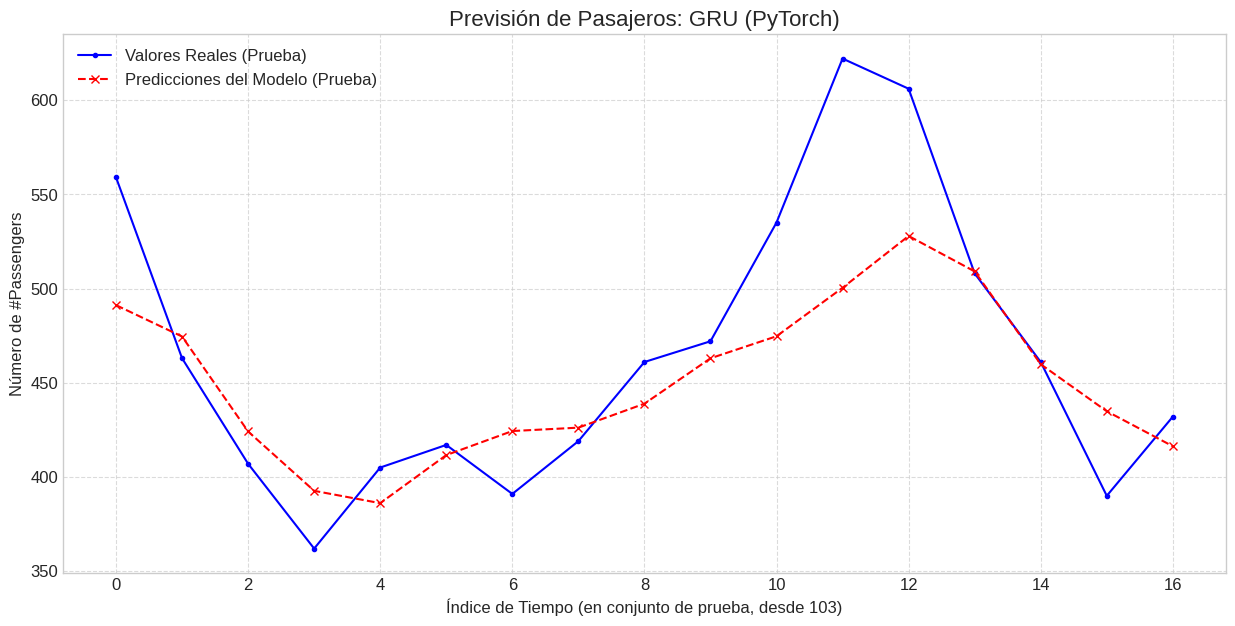

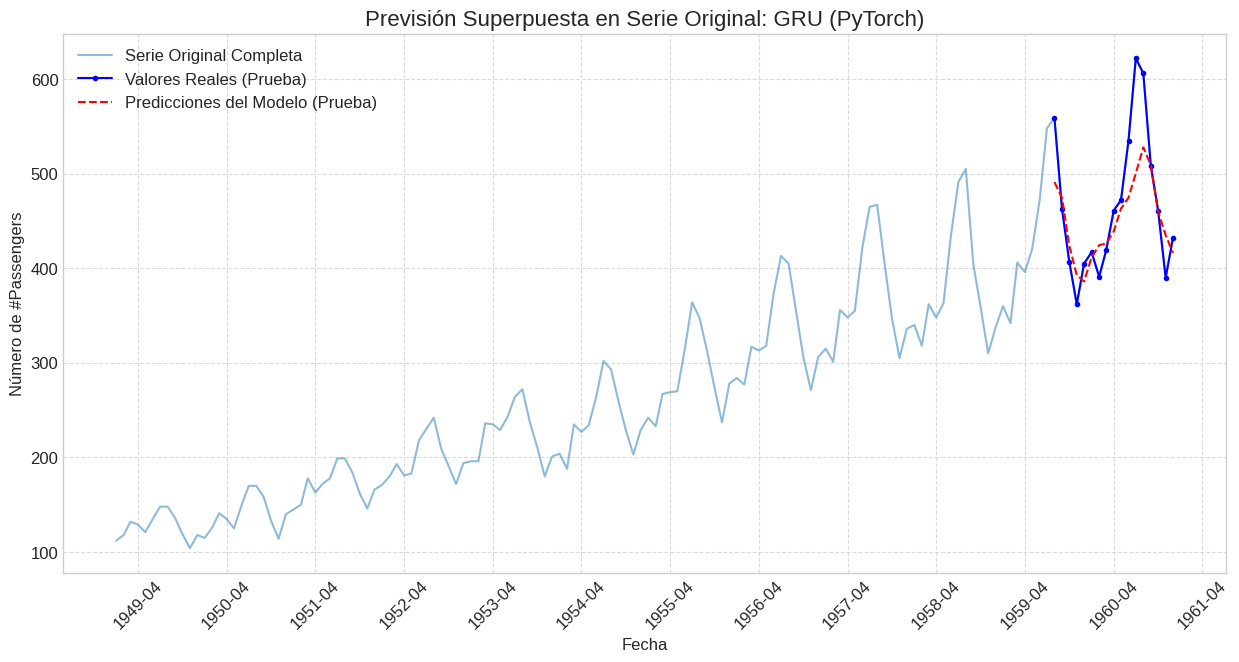

In [8]:
# 8. Inferencia (Previsión) con el Mejor Modelo (PyTorch)
# ------------------------------------------------------------------------------

if mejor_modelo_rnn_pt is not None and test_dataloader_ts is not None and 'scaler' in locals():
    print(f"Usando: {nombre_mejor_modelo_rnn_pt} para la previsión.")
    mejor_modelo_rnn_pt.eval() # Modo evaluación

    # Obtener todas las predicciones y etiquetas del conjunto de prueba
    _, test_preds_scaled_tensor, test_labels_scaled_tensor = evaluate_model_ts(
        mejor_modelo_rnn_pt, test_dataloader_ts, criterion_ts, device
    )

    # Convertir a NumPy y desescalar
    test_preds_scaled_np = test_preds_scaled_tensor.numpy()
    test_labels_scaled_np = test_labels_scaled_tensor.numpy()

    # `scaler` fue ajustado con .values.reshape(-1, 1), así que las predicciones también necesitan esa forma
    # y luego se desescalan.
    # Si y_test fue (num_samples, 1), entonces test_preds_scaled_np y test_labels_scaled_np también lo son.
    test_preds_descaled = scaler.inverse_transform(test_preds_scaled_np)
    test_labels_descaled = scaler.inverse_transform(test_labels_scaled_np)

    # Calcular RMSE en la escala original
    rmse_original_scale = math.sqrt(mean_squared_error(test_labels_descaled, test_preds_descaled))
    print(f"RMSE de previsión en escala original: {rmse_original_scale:.2f} pasajeros")

    # Graficar las previsiones vs los valores reales
    plt.figure(figsize=(15, 7))
    plt.plot(test_labels_descaled, label='Valores Reales (Prueba)', color='blue', marker='.')
    plt.plot(test_preds_descaled, label='Predicciones del Modelo (Prueba)', color='red', linestyle='--', marker='x')
    plt.title(f'Previsión de Pasajeros: {nombre_mejor_modelo_rnn_pt}', fontsize=16)
    plt.xlabel(f'Índice de Tiempo (en conjunto de prueba, desde {len(train_data_scaled) - SEQUENCE_LENGTH})', fontsize=12)
    plt.ylabel(f'Número de {passengers_col_name}', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Graficar sobre la serie temporal original (parte de prueba)
    # Necesitamos los índices de fecha correctos para la parte de prueba
    test_dates = time_series_data.index[train_size + SEQUENCE_LENGTH : train_size + SEQUENCE_LENGTH + len(test_labels_descaled)]

    plt.figure(figsize=(15,7))
    plt.plot(time_series_data.index, time_series_data.values, label="Serie Original Completa", alpha=0.5)
    plt.plot(test_dates, test_labels_descaled, label='Valores Reales (Prueba)', color='blue', marker='.')
    plt.plot(test_dates, test_preds_descaled, label='Predicciones del Modelo (Prueba)', color='red', linestyle='--')
    plt.title(f'Previsión Superpuesta en Serie Original: {nombre_mejor_modelo_rnn_pt}', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel(f'Número de {passengers_col_name}', fontsize=12)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12)) # Marcas cada 12 meses
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No se puede realizar inferencia: modelo no entrenado, dataloader de prueba no disponible o scaler no definido.")

## **9. Guardar el Mejor Modelo (PyTorch)**

Guardaremos el `state_dict` del mejor modelo RNN entrenado.

In [9]:
# 9. Guardar el Mejor Modelo (PyTorch)
# ------------------------------------------------------------------------------

if mejor_modelo_rnn_pt is not None:
    modelos_rnn_guardados_dir_pt = "modelos_rnn_pytorch_guardados"
    if not os.path.exists(modelos_rnn_guardados_dir_pt):
        os.makedirs(modelos_rnn_guardados_dir_pt)

    timestamp_rnn_pt = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    nombre_archivo_limpio_rnn_pt = nombre_mejor_modelo_rnn_pt.replace(" (PyTorch)", "").replace(" ", "_")
    nombre_archivo_modelo_rnn_pt = f"{nombre_archivo_limpio_rnn_pt}_{timestamp_rnn_pt}_ts.pth"
    ruta_guardado_modelo_rnn_pt = os.path.join(modelos_rnn_guardados_dir_pt, nombre_archivo_modelo_rnn_pt)

    print(f"Guardando el state_dict del mejor modelo ({nombre_mejor_modelo_rnn_pt}) en: {ruta_guardado_modelo_rnn_pt}")
    torch.save(mejor_modelo_rnn_pt.state_dict(), ruta_guardado_modelo_rnn_pt)
    print("State_dict del modelo RNN guardado exitosamente.")

    # print("\nEjemplo de cómo cargar el modelo RNN (comentado):")
    # if nombre_mejor_modelo_rnn_pt == "LSTM (PyTorch)":
    #     modelo_cargado_rnn_pt = LSTMModel(INPUT_SIZE_RNN, HIDDEN_SIZE_RNN, NUM_LAYERS_RNN, OUTPUT_SIZE_RNN)
    # else: # Asumir GRU
    #     modelo_cargado_rnn_pt = GRUModel(INPUT_SIZE_RNN, HIDDEN_SIZE_RNN, NUM_LAYERS_RNN, OUTPUT_SIZE_RNN)
    #
    # modelo_cargado_rnn_pt.load_state_dict(torch.load(ruta_guardado_modelo_rnn_pt, map_location=device))
    # modelo_cargado_rnn_pt.to(device)
    # modelo_cargado_rnn_pt.eval()
    # print(f"Modelo RNN '{nombre_mejor_modelo_rnn_pt}' cargado y listo para inferencia en {device}.")
else:
    print("No hay un mejor modelo RNN para guardar (posiblemente por fallo en carga de datos o entrenamiento).")

Guardando el state_dict del mejor modelo (GRU (PyTorch)) en: modelos_rnn_pytorch_guardados/GRU_20250507-195409_ts.pth
State_dict del modelo RNN guardado exitosamente.


## **Conclusiones y Próximos Pasos (RNN para Series Temporales en PyTorch)**

En este notebook, hemos construido un sistema de previsión de series temporales usando LSTMs y GRUs en PyTorch:
1.  Cargamos y exploramos el dataset "Air Passengers".
2.  Preprocesamos los datos: escalado y creación de secuencias de entrada-salida.
3.  Definimos `Dataset` y `DataLoader` de PyTorch para manejar los datos.
4.  Implementamos modelos LSTM y GRU.
5.  Creamos bucles de entrenamiento y evaluación, y entrenamos los modelos.
6.  Realizamos previsiones y las comparamos con los valores reales, desescalando para la interpretación.
7.  Guardamos el `state_dict` del mejor modelo.

**Posibles Próximos Pasos:**
* **Multivariado:** Adaptar para series temporales multivariadas (múltiples features de entrada).
* **Múltiples Pasos Futuros:** Modificar los modelos y la creación de secuencias para predecir más de un paso adelante a la vez.
* **Atención:** Incorporar mecanismos de atención en los modelos RNN.
* **Modelos Transformer:** Explorar arquitecturas basadas en Transformers, que han demostrado ser muy efectivas para secuencias.
* **Hiperparámetros:** Ajustar `SEQUENCE_LENGTH`, `HIDDEN_SIZE_RNN`, `NUM_LAYERS_RNN`, tasa de aprendizaje, optimizador, etc.
* **Análisis de Errores:** Investigar más a fondo los errores de predicción (ej. residuos).
* **Incorporar Features Exógenas:** Si hay variables adicionales que puedan influir en la serie temporal (ej. festivos, promociones).